## #Libraries required and being installed

In [64]:
!pip install pandas requests transformers streamlit networkx matplotlib fpdf dotenv
!pip install python-dotenv pandas requests plotly networkx pydantic tenacity



#API Key protection


In [ ]:
import os
os.environ["HF_TOKEN"] = "your_API_key"


Algorithm to get the linkage between various domains


In [62]:
import os
import logging
import requests
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tenacity import retry, stop_after_attempt, wait_exponential
from pydantic import BaseModel, confloat, field_validator
from typing import List, Optional, Dict
from dotenv import load_dotenv
from fpdf import FPDF

# Configure environment and logging
load_dotenv()
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class SectorRisk(BaseModel):
    """Data validation model for risk sectors."""
    sector: str
    risk_score: confloat(ge=0, le=100)  # Score must be between 0 and 100
    interdependencies: List[str]       # List of interdependencies
    risk_narrative: Optional[str] = None

    @field_validator("interdependencies")
    def validate_interdependencies(cls, v):
        if not v or len(v) < 1:
            raise ValueError("At least one interdependency must be provided")
        if len(v) != len(set(v)):
            raise ValueError("Duplicate interdependencies found")
        return v

class RiskAnalyzer:
    """Advanced risk analysis system with LLM integration."""
    def __init__(self):
        self.api_url = "https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.1"
        self.headers = {"Authorization": f"Bearer {os.getenv('HF_TOKEN')}"}
        self.sectors: List[SectorRisk] = []

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=4, max=10))
    def _query_llm(self, prompt: str) -> str:
        """Query the LLM with retry logic and error handling."""
        try:
            response = requests.post(
                self.api_url,
                headers=self.headers,
                json={"inputs": prompt},
                timeout=30
            )
            response.raise_for_status()
            if response.status_code == 200:
                result = response.json()
                if isinstance(result, list) and "generated_text" in result[0]:
                    return result[0]["generated_text"]
            logger.error(f"Unexpected API response: {response.text}")
            return "Analysis unavailable"
        except requests.exceptions.RequestException as e:
            logger.error(f"API request failed: {str(e)}")
            return "Service temporarily unavailable"

    def load_data(self, data: Dict):
        """Load and validate risk data."""
        try:
            df = pd.DataFrame(data)
            # Convert each row to dict for Pydantic
            self.sectors = [SectorRisk(**row.to_dict()) for _, row in df.iterrows()]
            logger.info(f"Successfully loaded {len(self.sectors)} sectors")
        except (ValueError, KeyError) as e:
            logger.error(f"Data validation error: {str(e)}")
            raise

    def generate_insights(self):
        """Generate risk narratives for each sector."""
        logger.info("Starting risk analysis process")
        for sector in self.sectors:
            prompt = self._create_prompt(sector)
            sector.risk_narrative = self._query_llm(prompt)
            logger.info(f"Generated insights for {sector.sector}")

    def _create_prompt(self, sector: SectorRisk) -> str:
        """Create a structured prompt for the LLM."""
        return (
            f"As a senior risk analyst, provide a detailed assessment of the {sector.sector} sector.\n"
            f"Risk Score: {sector.risk_score}/100\n"
            f"Key Interdependencies: {', '.join(sector.interdependencies)}\n"
            "Include analysis of:\n"
            "- Systemic vulnerabilities\n"
            "- Supply chain exposures\n"
            "- Geopolitical factors\n"
            "- Mitigation strategies\n"
            "Use professional financial terminology and maintain concise bullet points."
        )

class RiskVisualizer:
    """Creates visualizations for the risk data."""
    def __init__(self, sectors: List[SectorRisk]):
        # Use model_dump() (Pydantic V2) to get a dictionary representation
        self.df = pd.DataFrame([s.model_dump() for s in sectors])

    def create_risk_chart(self):
        """Generate and save a bar chart of sector risk scores."""
        plt.figure(figsize=(12, 7))
        plt.bar(self.df["sector"], self.df["risk_score"],
                color="#e74c3c", alpha=0.8, edgecolor="#2c3e50")
        plt.title("Sector Risk Assessment", fontsize=16, pad=20)
        plt.xlabel("Industry Sector", fontsize=12, labelpad=15)
        plt.ylabel("Risk Score (0-100)", fontsize=12, labelpad=15)
        plt.xticks(rotation=45, ha="right")
        plt.grid(axis="y", alpha=0.3)
        plt.tight_layout()
        plt.savefig("risk_scores.png", dpi=300, bbox_inches="tight")
        plt.close()

    def create_dependency_network(self):
        """Generate and save a network graph of sector interdependencies."""
        G = nx.Graph()
        for sector in self.df.to_dict("records"):
            G.add_node(sector["sector"], type="sector")
            for dep in sector["interdependencies"]:
                G.add_node(dep, type="dependency")
                G.add_edge(sector["sector"], dep)
        plt.figure(figsize=(14, 10))
        pos = nx.kamada_kawai_layout(G)
        node_colors = ["#e74c3c" if G.nodes[n]["type"] == "sector" else "#3498db" for n in G.nodes]
        node_sizes = [1200 if G.nodes[n]["type"] == "sector" else 800 for n in G.nodes]
        nx.draw(G, pos, with_labels=True, node_color=node_colors,
                node_size=node_sizes, font_size=10, font_weight="bold",
                edge_color="#95a5a6", width=1.5)
        plt.title("Sector Interdependency Network", fontsize=14, pad=20)
        plt.savefig("dependency_network.png", dpi=300, bbox_inches="tight")
        plt.close()

class RiskReportGenerator(FPDF):
    """Generates a PDF report for the risk analysis."""
    def __init__(self):
        super().__init__()
        self.WIDTH = 210  # A4 width in mm
        self.HEIGHT = 297  # A4 height in mm

    def header(self):
        self.set_font("Arial", "B", 16)
        self.cell(0, 10, "Systemic Risk Analysis Report", 0, 1, "C")

    def footer(self):
        self.set_y(-15)
        self.set_font("Arial", "I", 8)
        self.cell(0, 10, f"Page {self.page_no()}", 0, 0, "C")

    def add_section(self, title: str, body: str):
        self.set_font("Arial", "B", 12)
        self.cell(0, 10, title, 0, 1)
        self.set_font("Arial", "", 10)
        self.multi_cell(0, 8, body)
        self.ln(5)

if __name__ == "__main__":
    risk_data = {
        "sector": ["Energy", "Finance", "Healthcare"],
        "risk_score": [85, 70, 75],
        "interdependencies": [["Finance", "Healthcare"], ["Energy", "Healthcare"], ["Energy", "Finance"]],
        "Weights": [1.1, 1.2, 0.9]  # This field is not used in the model
    }

    analyzer = RiskAnalyzer()
    visualizer = RiskVisualizer([])  # Will be repopulated
    report = RiskReportGenerator()

    try:
        analyzer.load_data(risk_data)
        analyzer.generate_insights()

        visualizer = RiskVisualizer(analyzer.sectors)
        visualizer.create_risk_chart()
        visualizer.create_dependency_network()

        report.add_page()
        report.add_section("Executive Summary", "Comprehensive risk analysis of key economic sectors")
        for sector in analyzer.sectors:
            report.add_section(
                f"Sector: {sector.sector} (Score: {sector.risk_score}/100)",
                sector.risk_narrative or "No insights available."
            )
        report.output("risk_report.pdf")
        logger.info("Professional report package generated successfully")
    except Exception as e:
        logger.error(f"Critical failure: {str(e)}")


ERROR:__main__:API request failed: 402 Client Error: Payment Required for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.1
ERROR:__main__:API request failed: 402 Client Error: Payment Required for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.1
ERROR:__main__:API request failed: 402 Client Error: Payment Required for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.1


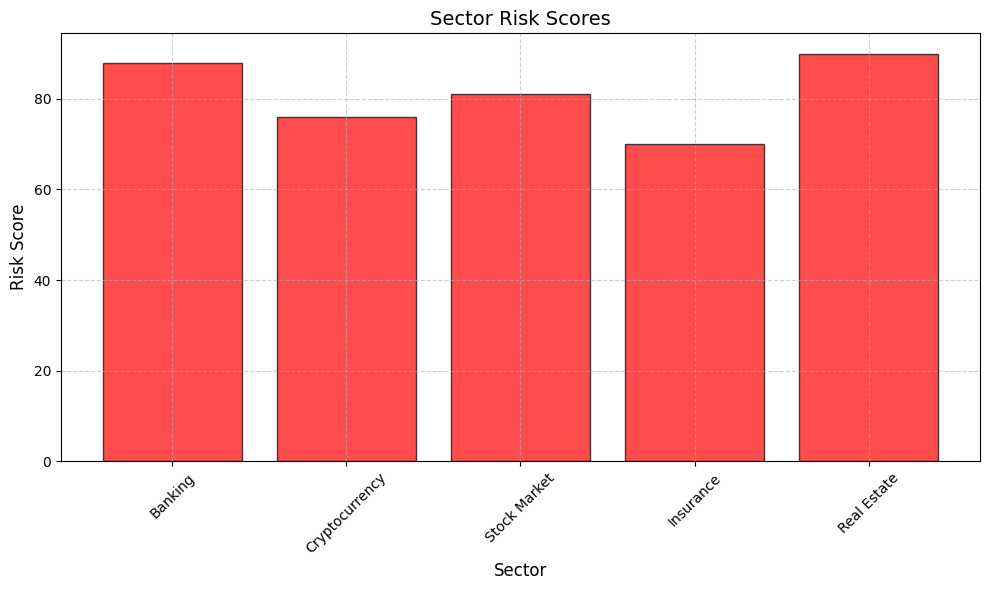

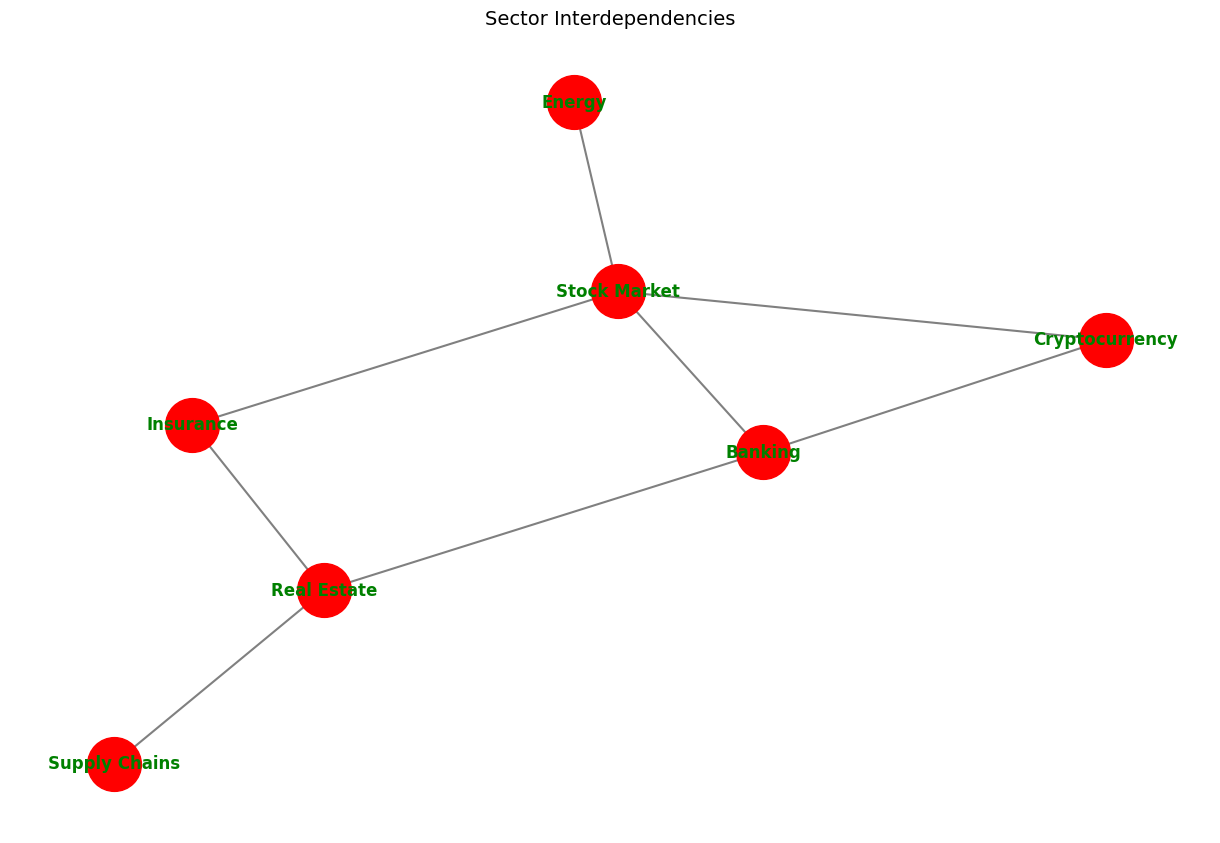

In [58]:


# Plot Bar Chart with Aesthetic Improvements
plt.figure(figsize=(10, 6))
plt.bar(df['Sector'], df['Risk_Score'], color='red', alpha=0.7, edgecolor='black')
plt.title("Sector Risk Scores", fontsize=14)
plt.xlabel("Sector", fontsize=12)
plt.ylabel("Risk Score", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Network Graph Visualization with Improved Layout
G = nx.Graph()
for _, row in df.iterrows():
    G.add_node(row['Sector'])
    for edge in row['Interdependencies']:
        G.add_node(edge)
        G.add_edge(row['Sector'], edge)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Consistent layout
nx.draw(G, pos, with_labels=True, node_color='red', node_size=1500, font_size=12,
        font_color='green', font_weight='bold', edge_color='gray', width=1.5)
plt.title("Sector Interdependencies", fontsize=14)
plt.show()


In [60]:
import os
import logging
import requests
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tenacity import retry, stop_after_attempt, wait_exponential
from pydantic import BaseModel, confloat, field_validator
from typing import List, Optional, Dict
from dotenv import load_dotenv
from fpdf import FPDF

# Load environment variables and configure logging
load_dotenv()
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Check for the Hugging Face token
HF_TOKEN = os.getenv('HF_TOKEN')
if not HF_TOKEN:
    logger.error("Hugging Face Token (HF_TOKEN) is missing in .env file.")
    raise ValueError("HF_TOKEN not found in .env")

class SectorRisk(BaseModel):
    """Model for validating risk sector data."""
    sector: str
    risk_score: confloat(ge=0, le=100)  # Must be between 0 and 100
    interdependencies: List[str]       # List of interdependencies
    risk_narrative: Optional[str] = None

    @field_validator("interdependencies")
    def check_interdependencies(cls, v):
        if not v or len(v) < 1:
            raise ValueError("At least one interdependency must be provided")
        if len(v) != len(set(v)):
            raise ValueError("Duplicate interdependencies found")
        return v

class RiskAnalyzer:
    """Analyzes risk data and queries the LLM for insights."""
    def __init__(self):
        # Note: The model used below ("mistralai/Mistral-7B-Instruct-v0.3") may require payment.
        self.api_url = "https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.3"
        self.headers = {"Authorization": f"Bearer {HF_TOKEN}"}
        self.sectors: List[SectorRisk] = []

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=4, max=10))
    def _query_llm(self, prompt: str) -> str:
        """Query the LLM with retry logic and error handling."""
        try:
            response = requests.post(
                self.api_url,
                headers=self.headers,
                json={"inputs": prompt},
                timeout=30
            )
            response.raise_for_status()
            result = response.json()
            if isinstance(result, list) and "generated_text" in result[0]:
                return result[0]["generated_text"]
            logger.error("Unexpected API response: " + response.text)
            return "Analysis unavailable"
        except requests.exceptions.RequestException as e:
            logger.error("API request failed: " + str(e))
            return "Service temporarily unavailable"

    def load_data(self, data: Dict):
        """Load and validate risk data from a dictionary."""
        try:
            df = pd.DataFrame(data)
            self.sectors = [SectorRisk(**row.to_dict()) for _, row in df.iterrows()]
            logger.info(f"Successfully loaded {len(self.sectors)} sectors")
        except (ValueError, KeyError) as e:
            logger.error("Data validation error: " + str(e))
            raise

    def generate_insights(self):
        """Generate risk narratives for each sector."""
        logger.info("Starting risk analysis process")
        for sector in self.sectors:
            prompt = self._create_prompt(sector)
            sector.risk_narrative = self._query_llm(prompt)
            logger.info(f"Generated insights for {sector.sector}")

    def _create_prompt(self, sector: SectorRisk) -> str:
        """Create a structured prompt for the LLM."""
        return (
            f"As a senior risk analyst, provide a detailed assessment of the {sector.sector} sector.\n"
            f"Risk Score: {sector.risk_score}/100\n"
            f"Key Interdependencies: {', '.join(sector.interdependencies)}\n"
            "Include analysis of:\n"
            "- Systemic vulnerabilities\n"
            "- Supply chain exposures\n"
            "- Geopolitical factors\n"
            "- Mitigation strategies\n"
            "Use professional financial terminology and maintain concise bullet points."
        )

class RiskVisualizer:
    """Creates visualizations for the risk data."""
    def __init__(self, sectors: List[SectorRisk]):
        # Use model_dump() instead of dict() (Pydantic V2)
        self.df = pd.DataFrame([s.model_dump() for s in sectors])

    def create_risk_chart(self):
        """Generate and save a bar chart of sector risk scores."""
        plt.figure(figsize=(12, 7))
        plt.bar(self.df["sector"], self.df["risk_score"],
                color="#e74c3c", alpha=0.8, edgecolor="#2c3e50")
        plt.title("Sector Risk Assessment", fontsize=16, pad=20)
        plt.xlabel("Industry Sector", fontsize=12, labelpad=15)
        plt.ylabel("Risk Score (0-100)", fontsize=12, labelpad=15)
        plt.xticks(rotation=45, ha="right")
        plt.grid(axis="y", alpha=0.3)
        plt.tight_layout()
        plt.savefig("risk_scores.png", dpi=300, bbox_inches="tight")
        plt.close()

    def create_dependency_network(self):
        """Generate and save a network graph of sector interdependencies."""
        G = nx.Graph()
        for sector in self.df.to_dict("records"):
            G.add_node(sector["sector"], type="sector")
            for dep in sector["interdependencies"]:
                G.add_node(dep, type="dependency")
                G.add_edge(sector["sector"], dep)
        plt.figure(figsize=(14, 10))
        pos = nx.kamada_kawai_layout(G)
        node_colors = ["#e74c3c" if G.nodes[n]["type"] == "sector" else "#3498db" for n in G.nodes]
        node_sizes = [1200 if G.nodes[n]["type"] == "sector" else 800 for n in G.nodes]
        nx.draw(G, pos, with_labels=True, node_color=node_colors,
                node_size=node_sizes, font_size=10, font_weight="bold",
                edge_color="#95a5a6", width=1.5)
        plt.title("Sector Interdependency Network", fontsize=14, pad=20)
        plt.savefig("dependency_network.png", dpi=300, bbox_inches="tight")
        plt.close()

class RiskReportGenerator(FPDF):
    """Generates a PDF report for the risk analysis."""
    def __init__(self):
        super().__init__()
        self.WIDTH = 210  # A4 width in mm
        self.HEIGHT = 297  # A4 height in mm

    def header(self):
        self.set_font("Arial", "B", 16)
        self.cell(0, 10, "Systemic Risk Analysis Report", 0, 1, "C")

    def footer(self):
        self.set_y(-15)
        self.set_font("Arial", "I", 8)
        self.cell(0, 10, f"Page {self.page_no()}", 0, 0, "C")

    def add_section(self, title: str, body: str):
        self.set_font("Arial", "B", 12)
        self.cell(0, 10, title, 0, 1)
        self.set_font("Arial", "", 10)
        self.multi_cell(0, 8, body)
        self.ln(5)

if __name__ == "__main__":
    # Sample risk data for testing
    risk_data = {
        "sector": ["Energy", "Finance", "Healthcare"],
        "risk_score": [85, 70, 75],
        "interdependencies": [["Finance", "Healthcare"], ["Energy", "Healthcare"], ["Energy", "Finance"]],
    }

    analyzer = RiskAnalyzer()
    report = RiskReportGenerator()

    try:
        # Load and process the data
        analyzer.load_data(risk_data)
        analyzer.generate_insights()

        # Create visualizations
        visualizer = RiskVisualizer(analyzer.sectors)
        visualizer.create_risk_chart()
        visualizer.create_dependency_network()

        # Generate the PDF report
        report.add_page()
        report.add_section("Executive Summary", "Comprehensive risk analysis of key economic sectors")
        for sector in analyzer.sectors:
            report.add_section(
                f"Sector: {sector.sector} (Score: {sector.risk_score}/100)",
                sector.risk_narrative or "No insights available."
            )
        report.output("risk_report.pdf")
        logger.info("Professional report package generated successfully")
    except Exception as e:
        logger.error("Critical failure: " + str(e))


ERROR:__main__:API request failed: 402 Client Error: Payment Required for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.3
ERROR:__main__:API request failed: 402 Client Error: Payment Required for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.3
ERROR:__main__:API request failed: 402 Client Error: Payment Required for url: https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.3
